# Reinforcement Learning for Quantum Control

In [ ]:
# Install the dependencies
!pip install tensorflow
!pip install -q tf-agents
!pip install qiskit 
!pip install numpy

In [ ]:
!pip3 uninstall protobuf --yes
!pip3 uninstall python-protobuf --yes
!pip install protobuf

## General Structure

The goal of the project is to find an optimal pulse shape for a quantum gate. In this hackathon project, the aim is to do this without a physical model of the noise, but by learning the optimal pulse with reinforcement learning.

In general in Reinforcement Learning (RL), an agent tries to learn an optimal behaviour in an environment it can (partially) observe the results of its actions on. The agent acts on the environment with some action, which then transitions into a new state and the agent receives 'feedback' in terms of a reward. It is now the goal to optimise the reward.
![rl_illustration](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b/Reinforcement_learning_diagram.svg/497px-Reinforcement_learning_diagram.svg.png)

### Agent: `agent.py`
The agent in this project 'is the control hardware of a qubit'. As actions, it sends EM-pulses onto an imperfect qubit to achieve a certain quantum gate; it can observe the final state of the qubit and the reward is determined in terms of the fidelity of the final state and the theoretically optimal final state.

This is implemented via [tensorflow agents](https://www.tensorflow.org/agents); a number of technical aspects resulting from that are implemented in `agent.py` (e.g. replay buffer, episodes, action distribution, ..).

TODO: explain pulse shape implementation

### Environment: `environment.py`

TODO: explain enviroment with pulse builder

## Training

in the training, an `Agent` (see `agent.py`) is created and the tensorflow agents framework is used to train the action distribution via reinforcement learning

In [ ]:
from environment import QiskitEnv
import numpy as np
from tf_agents.environments import tf_py_environment
from agent import Agent
from qiskit.visualization import plot_bloch_multivector
import matplotlib as plt

# Learning Parameters
num_iterations = 1000

#In an iteration multiple episodes are collected together and a trajectory is built out of it.
#Later these trajectory is used for learning. Trajectory is added to a replay buffer and analysed together.
collect_episodes_per_iteration = 250  #
replay_buffer_capacity = 2000  


learning_rate = 1e-3  
num_eval_episodes = 2  
eval_interval = 50
num_intervals = 10
interval_length = 60


"""Environemnt which make use of Qiskit Pulse Simulator and pulse builder to simulate 
the dynamics of a qubit under the influence of a pulse. The RL agent interact with this 
environment through action defined as pulse lenght. Here a constant pulse of amplitude 1 
is used and applied for a time "pulse width". "pulse width" is the action that the agent 
takes here. The agent observes the state obtained with the action along with the Fidelity 
to the expected final state. Here initial state is fixed to |0> and target state is |1>

The pulse is designed as follows
  The process time is divided into "num_intervals" of length "interval_length".
  For each interval a constant amplitude of range(0,1) is defined by the agent
  delay the mesearement channel for num_intervals*interval_length + 10 time and make mesurement.
TODO: Make the environement more gernect to handle different operators and initial states"""
environment =  QiskitEnv(np.array([1,0]), num_intervals, interval_length)

#convert the python environment to tensorflow compactible format for training.
tf_dumm = tf_py_environment.TFPyEnvironment(environment)
"""Get the reinfoce agent. Reward is the fielily to target state. Observation is the state"""
agent = Agent(num_iterations, collect_episodes_per_iteration, replay_buffer_capacity, learning_rate, num_eval_episodes, eval_interval, num_intervals, interval_length)
agent_reinforce = agent.get_agent(environment, 'reinforce', "without_noise_trained")
train_results = agent.train(tf_dumm, agent_reinforce)

In [ ]:
# useful to save the policy for later usage:
from tf_agents.policies import policy_saver
policy_dir = "policy"
tf_policy_saver = policy_saver.PolicySaver(agent_reinforce.policy)
tf_policy_saver.save(policy_dir)

# Evaluation

In [ ]:
env_test = QiskitEnv(np.array([0,1]),5,100)
vector, fid, action, pulse_prog = agent.evaluate(agent_reinforce, env_test)
print("Fidelity : ", fid)
control_pulse = [act.numpy()[0][0] for act in action]
print("Control pulse", control_pulse)
env_test.get_state(control_pulse)
#plot_bloch_multivector(vector)
pulse_prog.draw()

# Load Best Policy

In [ ]:
import tensorflow as tf 
import numpy as np
from tensorflow.saved_model import load
from tf_agents import policies
from environment import QiskitEnv
import warnings
import logging, sys
def evaluate(policy, eval_py_env):
        eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)
        num_episodes = 1
        fidelity = []
        actions = []
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                actions.append(action_step.action)
        fidelity,state, pulse_prog = eval_py_env.get_state(actions)
        return state, fidelity, actions,pulse_prog

env_test = QiskitEnv(np.array([0,1]),5,100)
policy_dir = "best_policy"
saved_policy = load(policy_dir)
state, fidelity, actions,pulse_prog = evaluate(saved_policy,env_test)    
print("Showing the results of the best policy")
print("Fidelity : ",fidelity)
print("Initial State: ", [1,0])
print("Final State: ", state)
print("\n\n")
pulse_prog.draw()

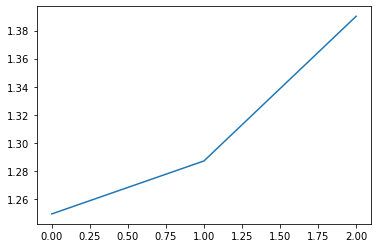

In [14]:
plt.pyplot.plot(train_results[2])